$$
H = \frac{|p|^2}2 + \alpha \sin(\theta t) s + \frac{\gamma}{|q|}
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha*np.sin(self.theta*t)

    def V(self, q, t):
        return self.gamma/np.linalg.norm(q)
    
    def Vq(self, q, t):
        return -q*self.gamma/np.linalg.norm(q)**3

In [4]:
e = 0.4
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))])]
init = init_ecc(e)

/Users/mseri/code/contact-integrators/integrators/common.py:14: MatplotlibDeprecationWarning: scipy.integrate.ode
  return plb.rk4(derivs, init, tspan)


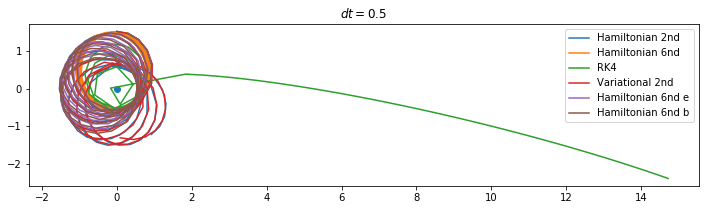

In [5]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 55

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

for (p0, q0) in [init]:
    plt.figure(figsize=(12,8))
    plt.title(f"$dt={dt}$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)

    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
#     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             label="Hamiltonian 6nd")
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             label="RK4")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             label="Variational 2nd")

    plt.plot(sole[:,1,0],
             sole[:,1,1],
             label="Hamiltonian 6nd e")
    plt.plot(solb[:,1,0],
             solb[:,1,1],
             label="Hamiltonian 6nd b")
#     plt.plot(solc[:,1,0],
#              solc[:,1,1],
#              label="Hamiltonian 6nd c")
    
    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')

    plt.legend(loc='upper right')
    plt.show()

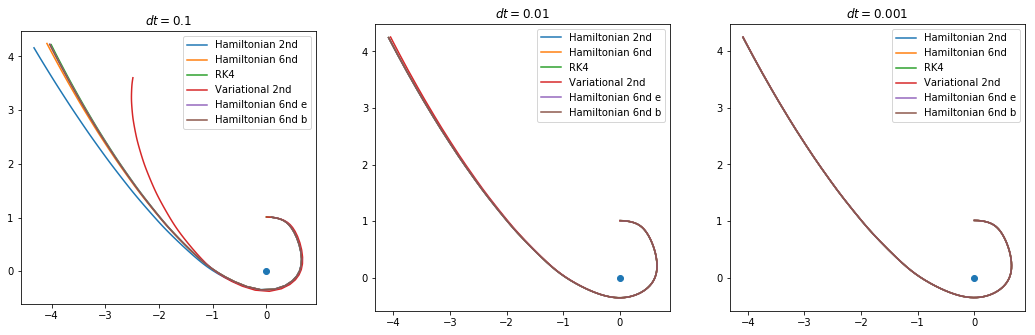

In [6]:
tpk = TimePerturbedKepler(1.7, 2*np.pi, -1)
tf = 10

(p0, q0) = init_ecc(0.01)

plt.figure(figsize=(18,10))

subplots = ["131", "132", "133"]

for i,precision in enumerate([10, 100, 1000]):
    dt = 1/precision
    tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))
    plt.subplot(subplots[i])
    plt.title(f"$dt={dt}$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    
    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
#     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             label="Hamiltonian 6nd")
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             label="RK4")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             label="Variational 2nd")

    plt.plot(sole[:,1,0],
             sole[:,1,1],
             label="Hamiltonian 6nd e")
    plt.plot(solb[:,1,0],
             solb[:,1,1],
             label="Hamiltonian 6nd b")
#     plt.plot(solc[:,1,0],
#              solc[:,1,1],
#              label="Hamiltonian 6nd c")
    
    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()

plt.show()

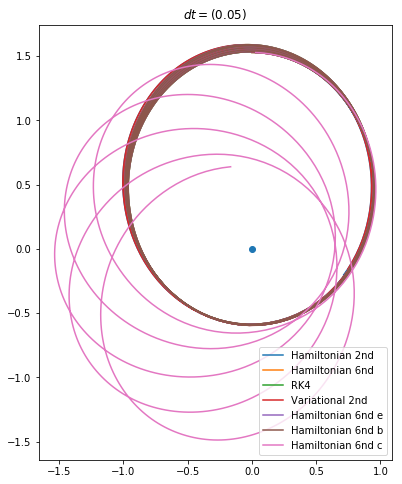

In [7]:
tpk = TimePerturbedKepler(-0.07, 2*np.pi, -1)
dt = 0.05
tf = 38

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

for (p0, q0) in [init]:
    plt.figure(figsize=(12,8))
    plt.title(f"$dt=({dt})$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    
    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             label="Hamiltonian 6nd")
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             label="RK4")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             label="Variational 2nd")
    
    plt.plot(sole[:,1,0],
             sole[:,1,1],
             label="Hamiltonian 6nd e")
    plt.plot(solb[:,1,0],
             solb[:,1,1],
             label="Hamiltonian 6nd b")
    plt.plot(solc[:,1,0],
             solc[:,1,1],
             label="Hamiltonian 6nd c")

    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')

    plt.legend()
    plt.show()

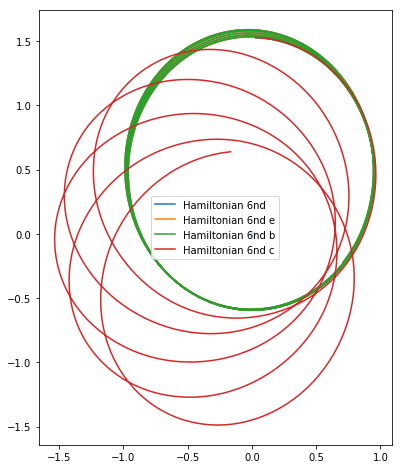

In [8]:
solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    
sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
plt.figure(figsize=(12,8))
plt.plot(solm[:,1,0],
         solm[:,1,1],
         label="Hamiltonian 6nd")
plt.plot(sole[:,1,0],
         sole[:,1,1],
         label="Hamiltonian 6nd e")
plt.plot(solb[:,1,0],
         solb[:,1,1],
         label="Hamiltonian 6nd b")
plt.plot(solc[:,1,0],
         solc[:,1,1],
         label="Hamiltonian 6nd c")

plt.scatter(0,0)

plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()